### Read files

In [ ]:
import sys
from resource import *
import time
import psutil
import numpy as np
import math
import re

def insert_string(string, index):
    ret_string = string[:index+1] + string + string[index+1:]
    return ret_string

def get_strings(file_name):
  indicator = False
  indices1 = []
  indices2 = []
  with open(file_name) as f:
      base1 = f.readline().strip()
      for line in f:
        if not bool(re.search(r'\d', line)):
          base2 = line.strip()
          indicator = True
        elif not indicator:
          indices1.append(line)
        else:
          indices2.append(line)

  indices1 = list(map(str.strip, indices1))
  indices2 = list(map(str.strip, indices2))

  new_base1 = base1
  for i in indices1:
    new_base1 = insert_string(new_base1, int(i))

  new_base2 = base2
  for i in indices2:
    new_base2 = insert_string(new_base2, int(i))
  
  return (new_base1, new_base2, len(new_base1) + len(new_base2))

In [ ]:
inputs = []

for i in range(1, 16):
  inputs.append(get_strings("in" + str(i) + ".txt"))

### Functions

In [ ]:
alpha = {"AA": 0, "AC": 110, "AG": 48, "AT": 94,
                    "CC": 0, "CA": 110, "CG": 118,"CT": 48,
                    "GG": 0, "GA": 48,  "GC": 118,"GT": 110,
                    "TT": 0, "TA": 94,  "TC": 48, "TG": 110}  

delta = 30

def efficient_align(x, y):
    if len(x) < 2 or len(y) < 2:
        return align(x, y)

    Y_prefix = Y_prefix_align(x[:math.floor(len(x) / 2)], y)
    Y_suffix = Y_suffix_align(x[math.floor(len(x) / 2):], y)

    best = float("inf")
    for q in range(0, len(y)+1):
      cost = Y_prefix[q] + Y_suffix[len(y) - q]
      if cost < best:
        bestq = q
        best = cost
    
    align_l = efficient_align(x[:math.floor(len(x) / 2)], y[:bestq])
    align_r = efficient_align(x[math.floor(len(x) / 2):], y[bestq:])
    l = [align_l[r] + align_r[r] for r in range(3)]

    return [align_l[r] + align_r[r] for r in range(3)]


def Y_prefix_align(x, y):
    dp = np.zeros([len(x) + 1, len(y) + 1]) 
    dp[0,0:(len(y) + 1)] = [ i * delta for i in range(len(y) + 1)]
    
    for i in range(1, len(x) + 1):
        dp[1][0] = i * delta
        for j in range(1, len(y) + 1):
            dp[1][j] = min(dp[0][j - 1] + alpha[x[i - 1] + y[j - 1]],
                            dp[0][j] + delta,
                            dp[1][j - 1] + delta)
        for j in range(len(y)+1):
            dp[0][j] = dp[1][j]
    final = dp[1]
    return final

def Y_suffix_align(x, y):
    dp = np.zeros([len(x) + 1, len(y) + 1]) 
    dp[0,0:(len(y) + 1)] = [ i * delta for i in range(len(y) + 1)]  

    for i in range(1, len(x) + 1):
        dp[1][0] = i * delta
        for j in range(1, len(y) + 1):
            dp[1][j] = min(dp[0][j - 1] + alpha[x[len(x) - i] + y[len(y) - j]],
                            dp[0][j] + delta,
                            dp[1][j - 1] + delta)
        for j in range(len(y) + 1):
            dp[0][j] = dp[1][j]
    final = dp[1]

    return final


def align(x, y):
    dp = np.zeros([len(x) + 1, len(y) + 1]) 
    dp[0:(len(x) + 1),0] = [ i * delta for i in range(len(x) + 1)]
    dp[0,0:(len(y) + 1)] = [ i * delta for i in range(len(y) + 1)]
 
    i = 1
    while i <= len(x):
        j = 1
        while j <= len(y):
            if x[i - 1] == y[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j - 1] + alpha[x[i - 1] + y[j - 1]],
                               dp[i - 1][j] + delta,
                               dp[i][j - 1] + delta)
            j += 1
        i += 1
     
    i = len(x)
    j = len(y)
    seq1 = ""
    seq2 = ""
 
    while not (i == 0 or j == 0):
        if (dp[i - 1][j - 1] + alpha[x[i - 1] + y[j - 1]]) == dp[i][j]:
            seq1 = x[i - 1] + seq1
            seq2 = y[j - 1] + seq2
            i -= 1
            j -= 1
         
        elif (dp[i - 1][j] + delta) == dp[i][j]:
            seq1 = x[i - 1] + seq1
            seq2 = "_" + seq2
            i -= 1
         
        elif (dp[i][j - 1] + delta) == dp[i][j]:       
            seq1 = "_" + seq1
            seq2 = y[j - 1] + seq2
            j -= 1

    while i:
        seq1 = x[i - 1] + seq1
        seq2 = "_" + seq2
        i -= 1

    while j:
        seq1 = "_" + seq1
        seq2 = y[j - 1] + seq2
        j -= 1

    return seq1, seq2, dp[len(x)][len(y)]

### Time and memory functions

In [ ]:
def process_memory():
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_consumed = int(memory_info.rss/1024)
    return memory_consumed

In [ ]:
time_data_standard = []
mem_data_standard = []

for i in inputs:
  # standard alg
  start_time = time.time()
  align(i[0], i[1])
  end_time = time.time()
  time_taken = (end_time - start_time) * 1000
  time_data_standard.append((time_taken, i[2]))
  mem_data_standard.append((process_memory(), i[2]))

In [ ]:
time_data_efficient = []
mem_data_efficient = []

for i in inputs:
  # efficient alg
  start_time = time.time()
  efficient_align(i[0], i[1])
  end_time = time.time()
  time_taken = (end_time - start_time) * 1000
  time_data_efficient.append((time_taken, i[2]))
  mem_data_efficient.append((process_memory(), i[2]))

In [ ]:
for i in time_data_standard:
  print(i)

print()

for i in time_data_efficient:
  print(i)

(0.4038810729980469, 16)
(5.0678253173828125, 64)
(20.47276496887207, 128)
(140.916109085083, 256)
(220.70693969726562, 384)
(388.0925178527832, 512)
(781.6433906555176, 768)
(1418.1711673736572, 1024)
(2777.930974960327, 1280)
(3465.5911922454834, 1536)
(3624.5687007904053, 2048)
(3997.0953464508057, 2560)
(6347.377061843872, 3072)
(6864.478826522827, 3584)
(9771.59070968628, 3968)

(0.6427764892578125, 16)
(10.175704956054688, 64)
(24.732112884521484, 128)
(95.71957588195801, 256)
(220.412015914917, 384)
(400.35080909729004, 512)
(895.7297801971436, 768)
(1557.4860572814941, 1024)
(2453.754186630249, 1280)
(3536.7887020111084, 1536)
(6291.191577911377, 2048)
(9803.410291671753, 2560)
(15202.080249786377, 3072)
(19319.928646087646, 3584)
(23805.87339401245, 3968)


In [ ]:
mem_data_s_diff = [i[0] - mem_data_standard[0][0] for i in mem_data_standard]
mem_data_e_diff = [i[0] - mem_data_efficient[0][0] for i in mem_data_efficient]

mem_data_s_diff.insert(0, 0)
mem_data_e_diff.insert(0,0)

In [ ]:
for i in range(len(mem_data_standard)):
  print(mem_data_standard[i], mem_data_s_diff[i])

(91864, 16) 0
(91864, 64) 0
(91868, 128) 0
(91900, 256) 4
(92148, 384) 36
(92412, 512) 284
(93908, 768) 548
(95752, 1024) 2044
(97064, 1280) 3888
(98376, 1536) 5200
(102068, 2048) 6512
(106552, 2560) 10204
(112344, 3072) 14688
(118928, 3584) 20480
(124736, 3968) 27064


In [ ]:
for i in mem_data_standard:
  print(i)

print()

for i in mem_data_efficient:
  print(i)

(91864, 16)
(91864, 64)
(91868, 128)
(91900, 256)
(92148, 384)
(92412, 512)
(93908, 768)
(95752, 1024)
(97064, 1280)
(98376, 1536)
(102068, 2048)
(106552, 2560)
(112344, 3072)
(118928, 3584)
(124736, 3968)

(124736, 16)
(124736, 64)
(124736, 128)
(124788, 256)
(124800, 384)
(124820, 512)
(124820, 768)
(124820, 1024)
(124868, 1280)
(124868, 1536)
(124948, 2048)
(124948, 2560)
(124948, 3072)
(137768, 3584)
(138296, 3968)


In [ ]:
mem_data_s = []
mem_data_e = []
for i in range(len(inputs)):
  mem_data_s.append((mem_data_s_diff[i], inputs[i][2]))
  mem_data_e.append((mem_data_e_diff[i], inputs[i][2]))

### Plots

Text(0, 0.5, 'Time')

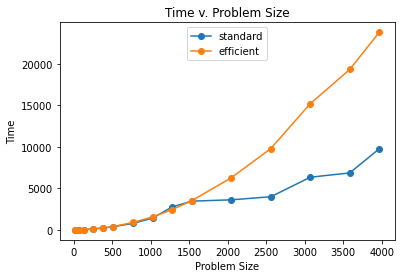

In [ ]:
import matplotlib.pyplot as plt

x1, y1 = zip(*time_data_standard)
x2, y2 = zip(*time_data_efficient)



plt.plot(y1, x1, marker='o', label='standard')
plt.plot(y2, x2, marker='o', label='efficient')
plt.legend(loc='upper center')

plt.title('Time v. Problem Size')
plt.xlabel('Problem Size')
plt.ylabel('Time')
#plt.show()

Text(0, 0.5, 'Memory')

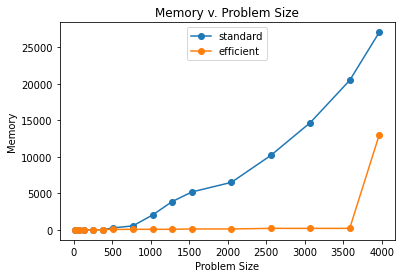

In [ ]:
# Memory v. Problem Size
x1, y1 = zip(*mem_data_s)
x2, y2 = zip(*mem_data_e)

plt.plot(y1, x1, marker='o', label='standard')
plt.plot(y2, x2, marker='o', label='efficient')
plt.legend(loc='upper center')

plt.title('Memory v. Problem Size')
plt.xlabel('Problem Size')
plt.ylabel('Memory')
#plt.show()

In [ ]:
import pandas as pd
# create DataFrame using data
problem_sizes = [i[2] for i in inputs]
time_s = [i[0] for i in time_data_standard]
mem_s = [i[0] for i in mem_data_s]
#print(problem_sizes)
#print(time_s)
#print(mem_s)


df = pd.DataFrame(
    {'Time': time_s,
     'Memory': mem_s,
     'Problem Size': problem_sizes
    })

time_e = [i[0] for i in time_data_efficient]
mem_e = [i for i in mem_data_e_diff[1:]]
#print(problem_sizes)
#print(time_e)
#print(mem_e)

#print(len(time_e))
#print(len(mem_e))
#print(len(problem_sizes))

df = pd.DataFrame(
    {'Time': time_e,
     'Memory': mem_e,
     'Problem Size': problem_sizes
    })

df

,Time,Memory,Problem Size
0,0.642776,0,16
1,10.175705,0,64
2,24.732113,0,128
3,95.719576,52,256
4,220.412016,64,384
5,400.350809,84,512
6,895.729780,84,768
7,1557.486057,84,1024
8,2453.754187,132,1280
9,3536.788702,132,1536


In [ ]:
import matplotlib.pyplot as plt

ps = [96, 128, 160, 256, 320, 384, 512, 576, 640, 768, 1024, 1152, 1280, 1536, 2048]

# for basic
memory = [79.999, 154.921, 160.097, 606.705, 605.233, 1201.502, 2394.012, 1205.685, 2415.073, 4763.227, 9507.939, 4771.061, 9501.692, 18964.845, 37891.162]
time =[0.0, 0.0, 0.015, 0.057, 0.058, 0.11, 0.213, 0.144, 0.271, 0.554, 0.89, 0.61, 1.216, 2.13, 6.216]

# for dc
memory_dc = [17.204, 24.254, 19.085, 40.562, 83.886, 43.134, 71.374, 208.849, 48.229, 128.780, 130.338, 458.453, 248.168, 250.314, 245.686 ]
time_dc = [0.014, 0.028, 0.033, 0.116, 0.113, 0.226, 0.451, 0.28, 0.461, 1.079, 2.232, 1.29, 2.545, 5.021, 10.811 ]

plt.title('Memory(KB) vs Problem Size')

plt.plot(ps, memory, label = "basic", marker='o', markerfacecolor='blue', markersize=5)
plt.plot(ps, memory_dc, label = "efficient", marker='o', markerfacecolor='orange', markersize=5)

plt.xlabel("Problem Size (m+n)")
plt.ylabel("Memory (KB)")
plt.legend()

plt.savefig('Memory_ProblemSize.png')
plt.show()

plt.title('Time(s) vs Problem Size')

plt.plot(ps, time, label = "basic", marker='o', markerfacecolor='blue', markersize=5)
plt.plot(ps, time_dc, label = "efficient", marker='o', markerfacecolor='orange', markersize=5)

plt.xlabel("Problem Size (m+n)")
plt.ylabel("Time (s)")
plt.legend()

#plt.savefig('Time_ProblemSize.png')
plt.show()